In [68]:
# Load necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# Loading the data

In [30]:
# Load data file
df_sigma_1 = pd.read_csv('./top_1/activity_sigma_1_steps_160000_size_80.txt', 
                         sep=' ', comment='#', index_col='Wave')
# Calculate wave size and duration
sizes = []
durations = []
for i in range(df_sigma_1.shape[0]):
    data_line = df_sigma_1.iloc[i]
    # Get size
    size = data_line.sum()
    sizes.append(size)
    
    # Get duration
    d = 0
    for j in range(df_sigma_1.shape[1]):
        col = 'layer_'+str(j+1)
        if data_line[col] == 0:
            break
        else:
            d += 1
    durations.append(d)
    
df_sigma_1['size'] = sizes
df_sigma_1['duration'] = durations

# Now get probabilities for size and duration
# Size:
size_prob_dict = {'size': list(np.sort(df_sigma_1['size'].unique())),
                  'counts': []}
for s in size_prob_dict['size']:
    c = df_sigma_1.loc[df_sigma_1['size'] == s].shape[0]
    size_prob_dict['counts'].append(c)
size_df = pd.DataFrame(size_prob_dict)
size_df['prob'] = size_df['counts'] / size_df['counts'].sum()

# Duration:
duration_prob_dict = {'duration': list(np.sort(df_sigma_1['duration'].unique())),
                  'counts': [], 'avg_size': []}
for d in duration_prob_dict['duration']:
    c = df_sigma_1.loc[df_sigma_1['duration'] == d].shape[0]
    avg_size = df_sigma_1.loc[df_sigma_1['duration'] == d, 'size'].mean()
    duration_prob_dict['counts'].append(c)
    duration_prob_dict['avg_size'].append(avg_size)
duration_df = pd.DataFrame(duration_prob_dict)
duration_df['prob'] = duration_df['counts'] / duration_df['counts'].sum()

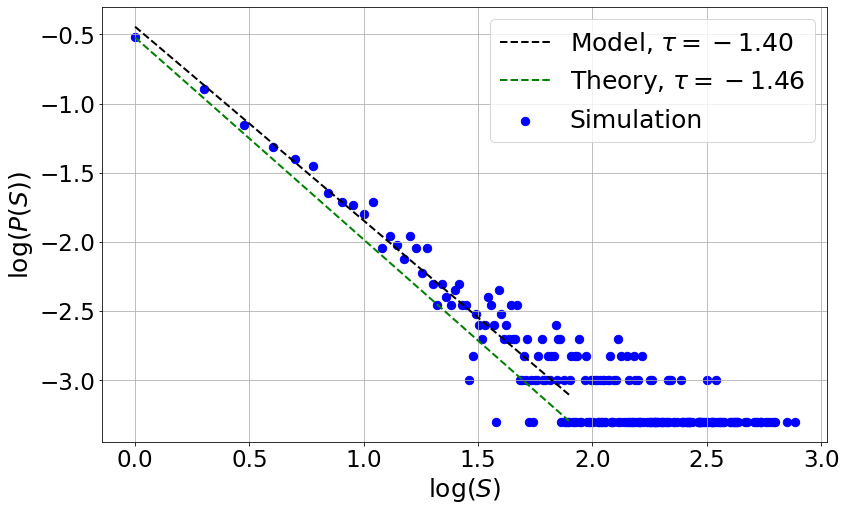

In [29]:
# Calculate critical exponent for avalanche size
reg_data = size_df.loc[size_df['size'] < 80]
X = np.array(np.log10(reg_data['size'])).reshape(-1, 1)
y = np.log10(reg_data['prob'])
size_linear = LinearRegression().fit(X,y)
size_linear_data = [
    size_linear.coef_[0] * x +\
    size_linear.intercept_ for x in np.log10(np.sort(reg_data['size']))]

# Save parameter
tau = size_linear.coef_[0]
theory_tau = -1.46

# Plot
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(13,8))
plt.scatter(np.log10(size_df['size']), 
            np.log10(size_df['prob']), s=70, c='b',
            label='Simulation')
plt.plot(np.log10(np.sort(reg_data['size'])),
         size_linear_data, c='k', lw=2, ls='--',
         label=r'Model, $\tau = %.2f$'%tau)
plt.plot(np.log10(np.sort(reg_data['size'])),
         np.log10(np.sort(reg_data['size'])) * theory_tau +\
         np.log10(reg_data['prob'].max()), 
         c='g', lw=2, ls='--',
         label=r'Theory, $\tau = %.2f$'%theory_tau)
plt.xlabel(r'$\log(S)$', fontsize=FONTSIZE)
plt.ylabel(r'$\log(P(S))$', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.legend(fontsize=FONTSIZE)
plt.grid(True);

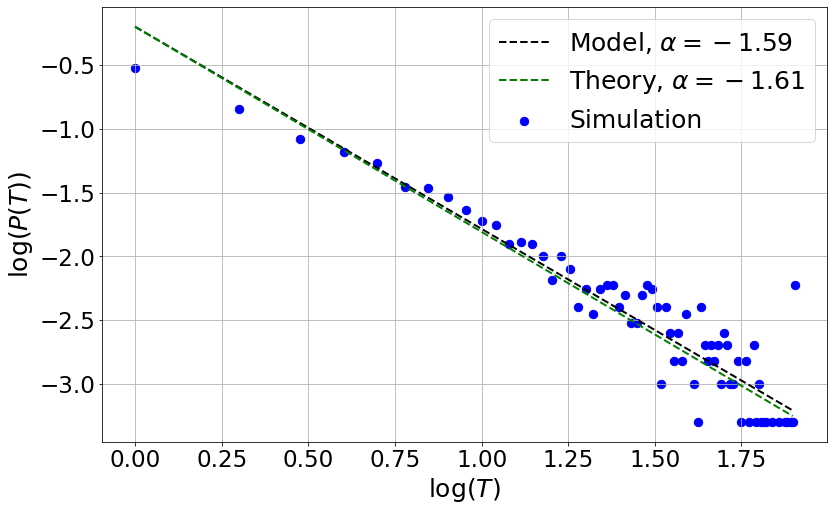

In [35]:
# Calculate critical exponent for avalanche duration
reg_data = duration_df.loc[duration_df['duration'] < 80]
X = np.array(np.log10(reg_data['duration'])).reshape(-1, 1)
y = np.log10(reg_data['prob'])
length_linear = LinearRegression().fit(X,y)
length_linear_data = [
    length_linear.coef_[0] * x +\
    length_linear.intercept_ for x in np.log10(np.sort(reg_data['duration']))]

# Save parameter
alpha = length_linear.coef_[0]
theory_alpha = -1.61

FONTSIZE = 25
fig, ax = plt.subplots(figsize=(13,8))
plt.scatter(np.log10(duration_df['duration']), 
            np.log10(duration_df['prob']), s=70, c='b',
            label='Simulation')
plt.plot(np.log10(np.sort(reg_data['duration'])),
         length_linear_data,  c='k', lw=2, ls='--',
         label=r'Model, $\alpha = %.2f$'%alpha)
plt.plot(np.log10(np.sort(reg_data['duration'])),
         np.log10(np.sort(reg_data['duration'])) * theory_alpha +\
         length_linear.intercept_, 
         c='g', lw=2, ls='--',
         label=r'Theory, $\alpha = %.2f$'%theory_alpha)
plt.xlabel(r'$\log(T)$', fontsize=FONTSIZE)
plt.ylabel(r'$\log(P(T))$', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.legend(fontsize=FONTSIZE)
plt.grid(True);

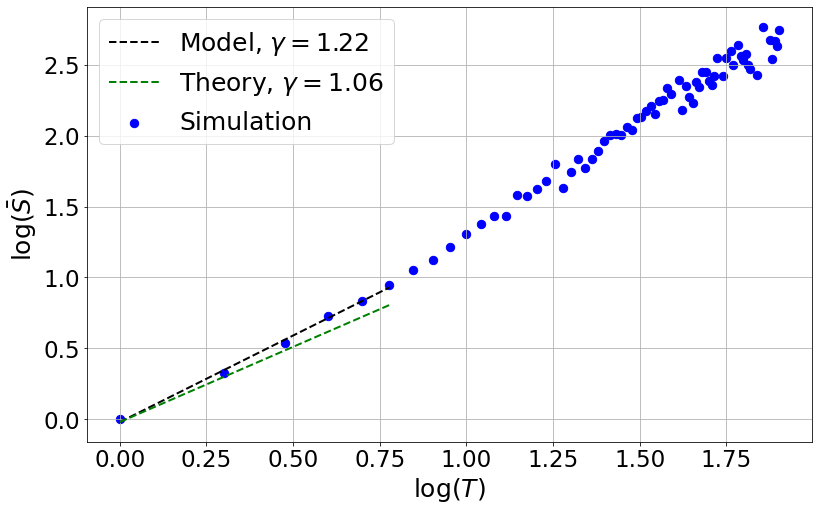

In [44]:
# Calculate critical exponent for avalanche duration vs size
reg_data = duration_df.loc[duration_df['avg_size'] < 10]
X = np.array(np.log10(reg_data['duration'])).reshape(-1, 1)
y = np.log10(reg_data['avg_size'])
gamma_linear = LinearRegression().fit(X,y)
gamma_linear_data = [
    gamma_linear.coef_[0] * x +\
    gamma_linear.intercept_ for x in np.log10(np.sort(reg_data['duration']))]

# Save parameter
gamma = gamma_linear.coef_[0]
theory_gamma = (theory_alpha - 1) / (theory_tau - 1)

FONTSIZE = 25
fig, ax = plt.subplots(figsize=(13,8))
plt.scatter(np.log10(duration_df['duration']), 
            np.log10(duration_df['avg_size']), s=70, c='b',
            label='Simulation')
plt.plot(np.log10(np.sort(reg_data['duration'])),
         gamma_linear_data,  c='k', lw=2, ls='--',
         label=r'Model, $\gamma = %.2f$'%gamma)
plt.plot(np.log10(np.sort(reg_data['duration'])),
         np.log10(np.sort(reg_data['duration'])) * theory_gamma +\
         gamma_linear.intercept_, 
         c='g', lw=2, ls='--',
         label=r'Theory, $\gamma = %.2f$'%theory_gamma)
plt.xlabel(r'$\log(T)$', fontsize=FONTSIZE)
plt.ylabel(r'$\log(\bar{S})$', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.legend(fontsize=FONTSIZE)
plt.grid(True);

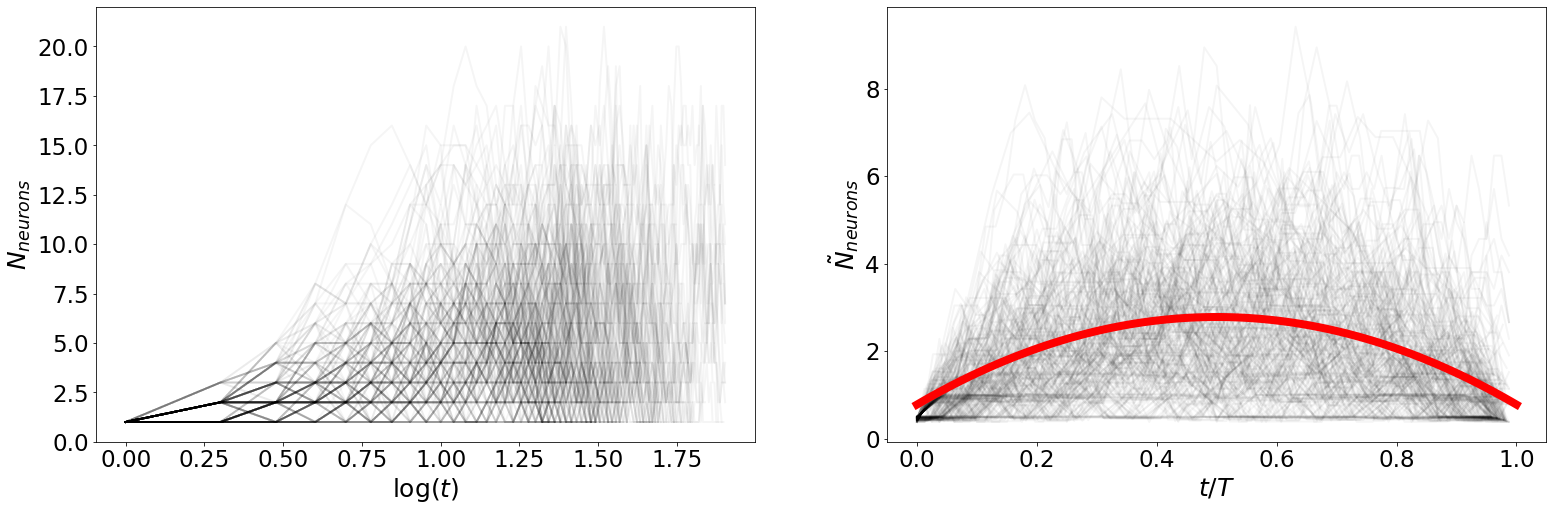

In [105]:
# Let's visualize the time profile of some avalanches
FONTSIZE = 25
LW = 2
ALPHA = 0.04
fig, (ax1, ax2) = plt.subplots(figsize=(26,8), nrows=1, ncols=2)
AV_ID = list(df_sigma_1.index)
X = []
y = []
for i in AV_ID:
    avalanche_values = list(df_sigma_1.loc[i][['layer_'+str(j+1) for j in range(df_sigma_1.loc[i]['duration'])]])
    avalanche_d = len(avalanche_values)
    if avalanche_d > 20:
        rel_steps = np.linspace(1, avalanche_d, num=avalanche_d)
        norm_steps = (rel_steps - 1) / avalanche_d
        #scaled_activity = (np.array(avalanche_values) - np.min(avalanche_values)) / 80#np.max(avalanche_values)
        scaled_activity = np.array(avalanche_values) / (avalanche_d ** (gamma - 1))
        
        # Save values to calculate regression
        X.extend(list(norm_steps))
        y.extend(list(scaled_activity))
        
        # Plot avalanche
        ax1.plot(np.log10(rel_steps), avalanche_values, 
                 lw=LW, c='k', alpha=ALPHA)
        ax2.plot(norm_steps, scaled_activity, 
                 lw=LW, c='k', alpha=ALPHA)
        
# Build regression
X = np.array(X)
y = np.array(y)
# We need to minimize the error function
def E(A):
    y_pred = A[0] * X * (X - 1) + A[1]
    return np.sqrt(np.mean(np.square(y - y_pred)))
A_opt = minimize(fun=E, x0=(1,0)).x
# Plot optimized function
x_func = np.linspace(0,1,num=100)
y_func = A_opt[0] * x_func * (x_func - 1) + A_opt[1]
ax2.plot(x_func, y_func, lw=4*LW, c='r')
        
for ax in [ax1,ax2]:
    ax.tick_params(labelsize=FONTSIZE-2)
ax1.set_xlabel(r'$\log(t)$', fontsize=FONTSIZE)   
ax1.set_ylabel(r'$N_{neurons}$', fontsize=FONTSIZE)
ax2.set_xlabel(r'$t/T$', fontsize=FONTSIZE)
ax2.set_ylabel(r'$\tilde{N}_{neurons}$', fontsize=FONTSIZE);